# CNN model

This notebook trains a convolutional layer over the input probability distributions.

In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.data as udata
import utils.dists as udists
import utils.misc as u
import os
import losses

from functools import partial
from jrun import jin
from keras.layers import (Activation, Convolution1D, Convolution2D, Dense,
                          Dropout, Embedding, Flatten, Merge, Input)
from keras.layers.merge import Concatenate, concatenate
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.backend as K

## Setup notebook parameters

In [32]:
EXP_NAME = jin("exp", "cnn/seasons-14-to-5")
COMPONENTS = jin("components", ["kcde", "kde", "sarima"])
WEEK_NUMBER = jin("week", 2)
TEST_SPLIT_THRESH = jin("splitweek", 201143)

## Load data

In [33]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = udata.ComponentDataLoader("../data", name)

In [34]:
components = [Component(name) for name in COMPONENTS]
actual_dl = udata.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [35]:
REGION = None # Specify None for using all the data

y, Xs, yi = udata.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [cmp.loader for cmp in components]
)

for idx, cmp in enumerate(components):
    cmp.data = Xs[idx]

### Creating input matrices for model

In [36]:
X = udists.get_2d_features(Xs)
y = udists.wili_to_dists(y)

### Split based on year
We take items before a certain epiweek as train and rest as test

In [37]:
train_indices = yi[:, 0] < TEST_SPLIT_THRESH

## Model

In [38]:
def conv1D_distribution(n_components, n_bins):
    """
    One dimensional conv model over input distribution to give an output
    distribution

    Parameters
    ----------
    n_components : int
        Number of component distributions
    n_bins : int
        Number of bins in the prediction distribution
    """

    dist_input = Input(shape=(n_bins, n_components))
    dist_x = Convolution1D(32, 5, padding="same")(dist_input)
    dist_x = Convolution1D(10, 3, padding="same")(dist_x)
    dist_x = Flatten()(dist_x)
    dist_x = Dense(10, activation="tanh")(dist_x)
    dist_x = Dense(n_bins, activation="softmax")(dist_x)
    
    model = Model(inputs=dist_input, outputs=dist_x)

    return model

### Training

In [39]:
# model generator
def gen_model():
    return conv1D_distribution(X.shape[-1], X.shape[1])

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100,
    verbose=0
):
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=4, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=val_data)
    return history

100%|██████████| 14/14 [28:58<00:00, 139.18s/it]


,epochs,train_loss,val_loss
it-1,22.000000,3.145374,3.929398
it-2,9.000000,3.888589,4.227876
it-3,42.000000,3.070733,3.352426
it-4,44.000000,3.076592,3.156340
it-5,38.000000,3.096644,2.954097
it-6,23.000000,3.099083,3.678787
it-7,50.000000,3.065058,3.110897
it-8,45.000000,3.088247,3.026265
it-9,48.000000,3.074633,2.975400
it-10,41.000000,3.076434,3.139739


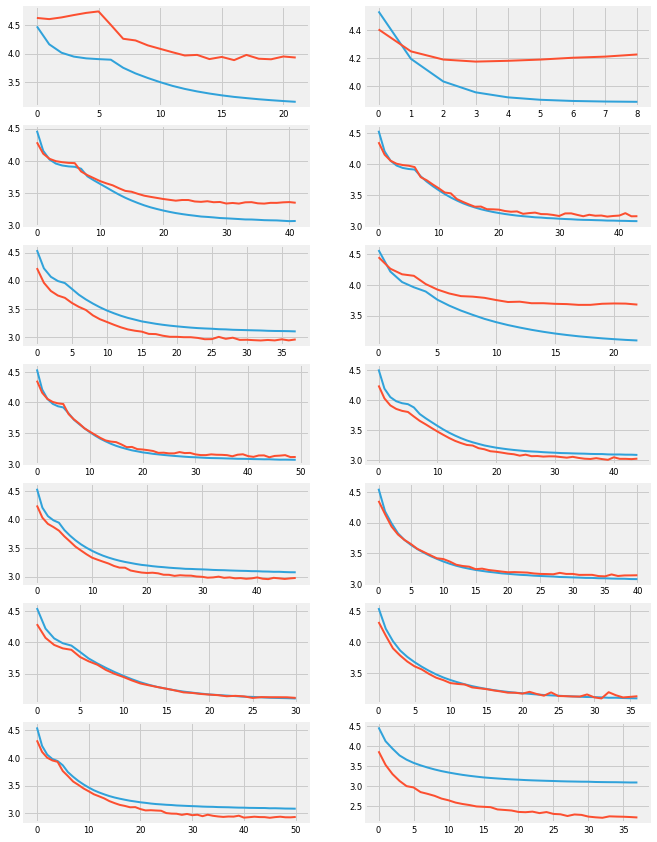

In [40]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    X[train_indices], y[train_indices], yi[train_indices]
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

3.0822464922056181

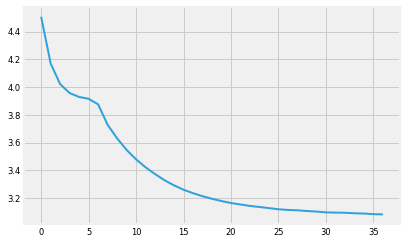

In [41]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(
    model,
    (X[train_indices], y[train_indices]),
    None, epochs=final_epochs)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [42]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

mdls = [*[cmp.name for cmp in components], "n-ensemble",
        "ave-ensemble", "prod-ensemble"]

eval_df = {mdl: [] for mdl in mdls}

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dists = [cmp.data[eval_indices] for cmp in components]
    n_dist = model.predict(X[eval_indices])
    
    dists = [
        *component_dists,
        n_dist,
        udists.mean_ensemble(component_dists),
        udists.prod_ensemble(component_dists)
    ]
    
    for name, output in zip(mdls, dists):
        eval_df[name].append(losses.mean_cat_cross(y[eval_indices], output))
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "all"]
eval_df = eval_df[mdls]

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs
}, f"{output_dir}/{WEEK_NUMBER}_summary.txt")
eval_df.to_csv(f"{output_dir}/{WEEK_NUMBER}_eval.csv")
eval_df

,kcde,kde,sarima,n-ensemble,ave-ensemble,prod-ensemble
nat,2.7828896831398224,3.299339772832448,2.6935385821956346,2.950401005776305,2.816118138348445,2.746702658554683
hhs1,2.6274682976465846,3.371582499944742,2.8076433964014766,2.7149100468346945,2.851544079495764,2.688160543213259
hhs2,3.1584048067951325,3.7113421772438557,3.2793888421891606,3.0857810707468736,3.3366928102183464,3.1285245424436385
hhs3,2.9576410974758907,3.4763135751503547,3.223620789488151,3.062066839713799,3.149928106035147,2.8607865061103412
hhs4,3.001231026048581,3.438596935720619,2.848855409353579,2.928696756300173,2.975943467411819,3.007148256797863
hhs5,2.870655261406503,3.410965133960844,2.8840748280905326,2.9029159412572256,2.9704042644294204,2.8230887043877186
hhs6,3.6313248194416645,4.4629125563709495,3.858251777358115,3.7156644871360376,3.9057256029249308,3.7855986070454066
hhs7,3.0211550819044684,3.4957810914191687,3.0872775746008103,3.0080153518601467,3.144911239701909,3.0870776514295986
hhs8,2.812872236951813,3.4342777563630933,3.0011221680647386,2.784659215494206,3.0373526637098753,2.895451481199775
hhs9,3.2002117806253323,3.6861028222702243,3.338688310018532,3.2355664121477226,3.3683582502356195,2.9416003046796675


## Plot random predictions

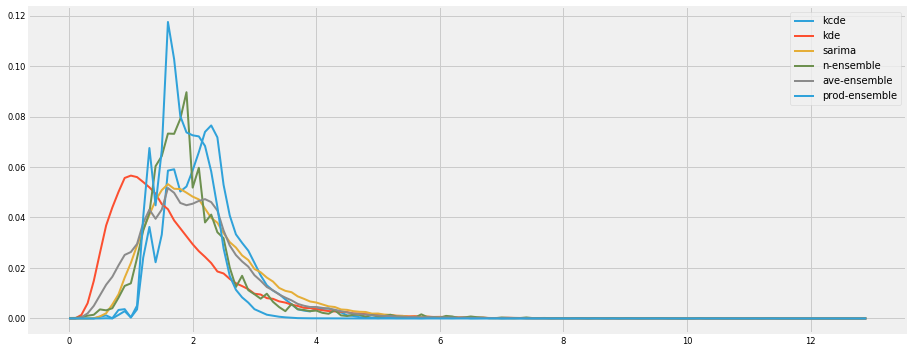

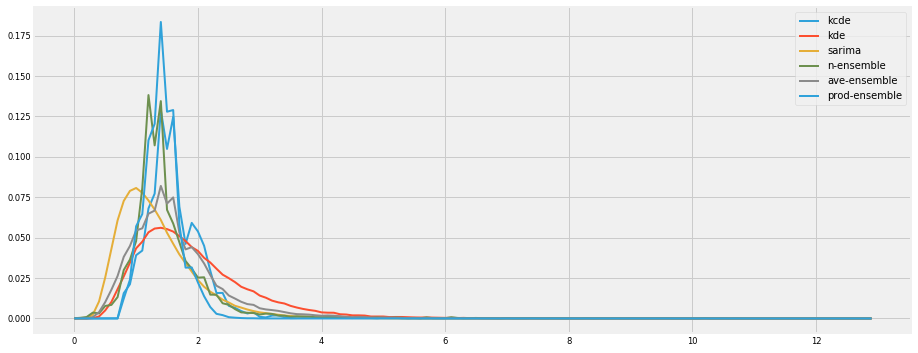

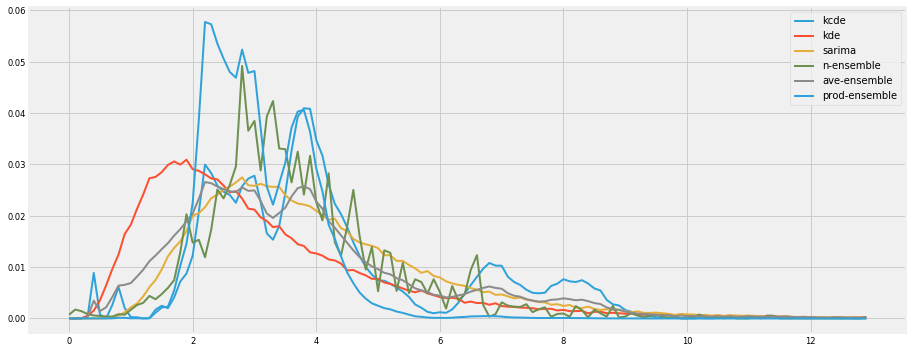

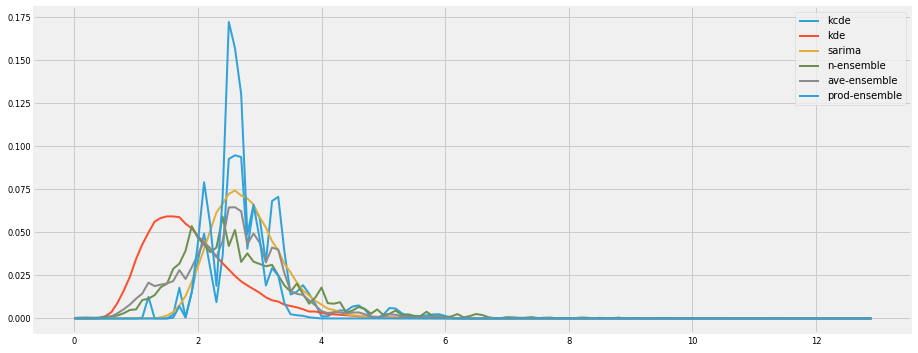

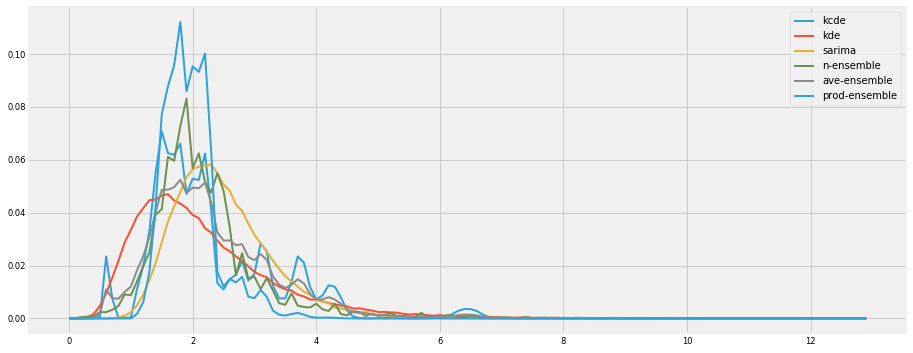

In [43]:
# Sample few of the examples
n_plots = 5
plot_indices = np.random.randint(0, y[~train_indices].shape[0], size=n_plots)

# y_plot_out = y[~train_indices][plot_indices]

component_dists = [cmp.data[~train_indices][plot_indices] for cmp in components]
n_dist = model.predict(X[~train_indices][plot_indices])

dists = [
    *component_dists,
    n_dist,
    udists.mean_ensemble(component_dists),
    udists.prod_ensemble(component_dists)
]

bins = np.linspace(0, 12.9, 130)
mdls = [*[cmp.name for cmp in components], "n-ensemble", "ave-ensemble", "prod-ensemble"]

for pidx in range(n_plots):
    plt.figure(figsize=(14, 6))
    for idx, mdl in enumerate(mdls):
        plt.plot(bins, dists[idx][pidx], label=mdl)
    
    # Plot actual line
#     plt.axvline(x=y_plot_out[pidx])
    
    plt.legend()